In [11]:
import re
import numpy as np
import pandas as pd
from wordcloud import WordCloud
font = r'./QingNiaoHuaGuangJianMeiHei-2.ttf'
import matplotlib.pyplot as plt
import jieba

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [12]:
df = pd.read_csv('./wuhan_sentiment.csv')
df.head()

,Unnamed: 0,text,sentiment_label,sentiment_key,positive_probs,negative_probs
0,0,【感染诺如病毒该如何应对？】诺如病毒是一组形态相似、抗原性略有不同的病毒颗粒，主要表现为腹泻...,0,negative,0.0064,0.9936
1,1,【多部门联手打击“炒猪团” ，保障生猪产品质量安全】最近一段时间，在部分地区出现了“炒猪团”...,0,negative,0.0025,0.9975
2,2,【健康科普】流感风暴来袭，这份秘籍必须收好了！近日，国家流感中心发布最新数据，截至2019年...,1,positive,0.9668,0.0332
3,3,#微博萧县#【我县多举措激活生猪养殖业】今年以来，萧县把扶持生猪生产作为落实民生“菜篮子”工...,0,negative,0.0077,0.9923
4,4,【农业农村部：加快恢复生猪生产】览富财经12月30日讯，农业农村部副部长表示，加快恢复生猪生...,0,negative,0.0063,0.9937


In [13]:
df.dropna(inplace=True)

In [14]:
# turn sentiment_label column into integer type
# turn sentiment_key column into String type
df['sentiment_label'] = df['sentiment_label'].astype(int)
df['sentiment_key'] = df['sentiment_key'].astype(str)

# select all rows with sentiment_label =0 or 1
# select all rows with sentiment_key = positive or negative
df_cleaned = df[df['sentiment_label'].isin([0, 1])& df['sentiment_key'].isin(['positive', 'negative'])][['text','sentiment_label']]
# order sentiment_label column acendingly
df_cleaned.sort_values(by=['sentiment_label'], ascending=True, inplace=True)
df_cleaned.reset_index(inplace=True)
df_cleaned.drop('index', axis=1, inplace=True)
df_cleaned

,text,sentiment_label
0,【感染诺如病毒该如何应对？】诺如病毒是一组形态相似、抗原性略有不同的病毒颗粒，主要表现为腹泻...,0
1,#坚决打赢疫情防控阻击战#【最新！蚌埠新增确诊病例1例情况公布】根据安徽省卫健委发布的最新疫...,0
2,#武汉新型冠状病毒肺炎疫情防控# 【#钻石公主号中国同胞将乘包机返港#】2月19日起，“钻石...,0
3,#武汉新型冠状病毒肺炎疫情防控# 【人社部引导农民工返工：#出家门上车门下车门进厂门#】人社...,0
4,【总台记者探访：#武汉大型商超不再对个人开放#，市民如何买菜？】#武汉居民生活物资由社区统一...,0
...,...,...
201828,【#为什么武汉新增病例高于湖北全省#？这个数据你需要看懂】今天湖北省疫情通报显示，湖北省新增...,1
201829,【致敬英雄，黑龙江多家景区对全国医护人员免费开放】为向全国支援武汉的医护工作者致敬，黑龙江多...,1
201830,#黑土巾帼抗疫情# 【视频--新冠病毒会长期存在吗？拐点来了吗？白岩松再次对话王辰】 在2...,1
201831,【#整栋楼解封后业主高喊加油# 疫情过后你最想做什么？】疫情过后最想做什么？走出家门，把想吃...,1


In [15]:
df['sentiment_label'].value_counts()

sentiment_label
1    158712
0     43121
Name: count, dtype: int64

In [16]:
text, sentiment = list(df_cleaned['text']), list(df_cleaned['sentiment_label'])

In [17]:
# import cn_stopwords.txt
stopwordlist = []
with open('./cn_stopwords.txt', 'r', encoding='utf-8') as file:
    for line in file.readlines():
        word = line.strip()
        if word:
            stopwordlist.append(word)
print(stopwordlist)

['$', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', '_', '“', '”', '、', '。', '《', '》', '收起全文d', '其中', '一', '一些', '一何', '一切', '一则', '一方面', '一旦', '一来', '一样', '一般', '一转眼', '万一', '上', '上下', '下', '不', '不仅', '不但', '不光', '不单', '不只', '不外乎', '不如', '不妨', '不尽', '不尽然', '不得', '不怕', '不惟', '不成', '不拘', '不料', '不是', '不比', '不然', '不特', '不独', '不管', '不至于', '不若', '不论', '不过', '不问', '与', '与其', '与其说', '与否', '与此同时', '且', '且不说', '且说', '两者', '个', '个别', '临', '为', '为了', '为什么', '为何', '为止', '为此', '为着', '乃', '乃至', '乃至于', '么', '之', '之一', '之所以', '之类', '乌乎', '乎', '乘', '也', '也好', '也罢', '了', '二来', '于', '于是', '于是乎', '云云', '云尔', '些', '亦', '人', '人们', '人家', '什么', '什么样', '今', '介于', '仍', '仍旧', '从', '从此', '从而', '他', '他人', '他们', '以', '以上', '以为', '以便', '以免', '以及', '以故', '以期', '以来', '以至', '以至于', '以致', '们', '任', '任何', '任凭', '似的', '但', '但凡', '但是', '何', '何以', '何况', '何处', '何时', '余外', '作为', '你', '你们', '使', '使得', '例如', '依', '依据', '依照', '便于', '俺', '俺们', '倘', '倘使', '倘或', '倘然', '倘若', '借', '假使', '假如', '假若', '傥然', '像', '儿', '先不先', '光是'

In [18]:
def preprocess(textdata):
    processedText = []
    
    # 定义适合中文的正则表达式模式
    urlPattern = r"(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)*\/?"
    userPattern = r'@[\w\u4e00-\u9fa5]+'  # 适应中文用户名
    
    for tweet in textdata:
        # 替换URL和用户名
        tweet = re.sub(urlPattern, '提到某链接', tweet)
        tweet = re.sub(userPattern, '某用户', tweet)
        
        # 使用jieba进行分词
        words = jieba.cut(tweet)
        
        tweetwords = []
        for word in words:
            # 使用中文停用词列表
            if word not in stopwordlist and word.strip():
                tweetwords.append(word)
        
        processedText.append(' '.join(tweetwords))
    
    return processedText


In [19]:
processedtext = preprocess(text)

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/3d/bcwmv_7x7sn98y9ydfzp841m0000gn/T/jieba.cache
Loading model cost 0.370 seconds.
Prefix dict has been built successfully.


In [23]:
processedtext[0]

'【 感染 诺如 病毒 应对 】 诺如 病毒 一组 形态 相似 抗原性 略有不同 病毒 颗粒 主要 表现 腹泻 呕吐 逐渐 出现 腹痛 恶心 头疼 发热 畏寒 症状 国际 通常 称之为 急性 胃肠炎 人体 感染 诺如 病毒 12 48 小时 出现 相应 症状 病毒 导致 人患 急性 胃肠炎 病情 轻微 不必 过于 担心 天 好转 预后 良好 病情 较为 严重 患者 应 及时 就医 谨 遵 医嘱 感染 对象 主要 成人 学龄儿童 寒冷 季节 呈现 高发 学校 幼儿园 医院 养老院 人群 密集 场所 容易 发生 聚集 性 疫情 特别 岁 以下 儿童 抵抗力 较差 容易 感染 目前 诺如 病毒 急性 胃肠炎 没有 特效药 物 没有 相应 疫苗 补液 对症 治疗 为主 患者 应 注意 充分 休息 清淡 饮食 诺如 病毒 传播 力较 强 家中 诺 病毒 急性 胃肠炎 患者 注意 不要 家属 过分 亲密 接触 避免 传染给 家人 患者 排泄物 呕吐物 容器 餐饮具 应用 含氯 消毒剂 重点 消毒 （ 来源 顺义区 卫生 计划生育 委员会 ） 收起 全文 d'

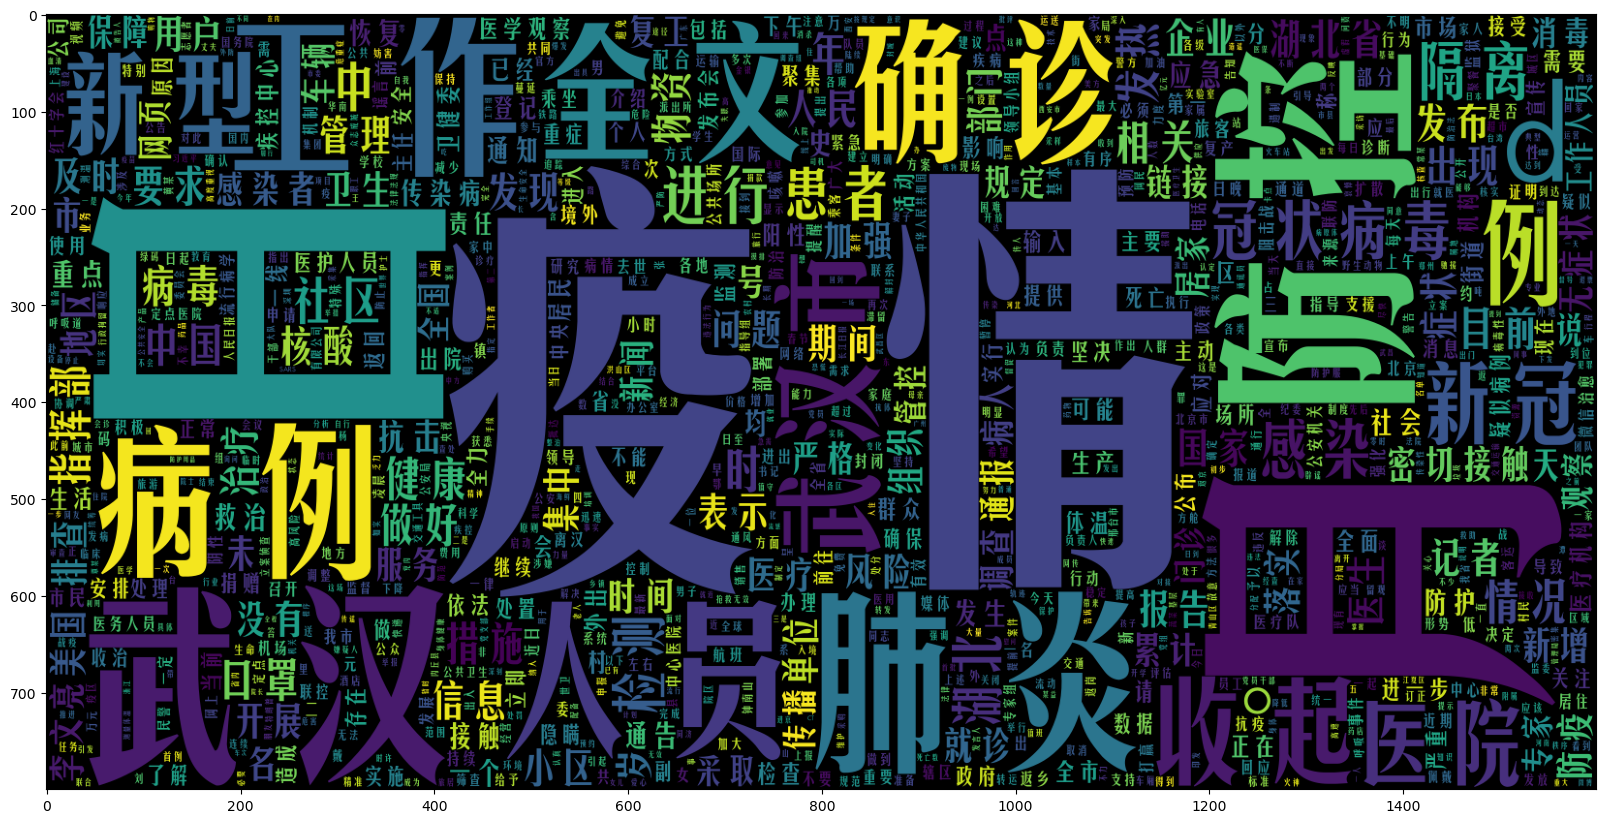

In [20]:
data_neg = processedtext[:43121]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800, font_path=font,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

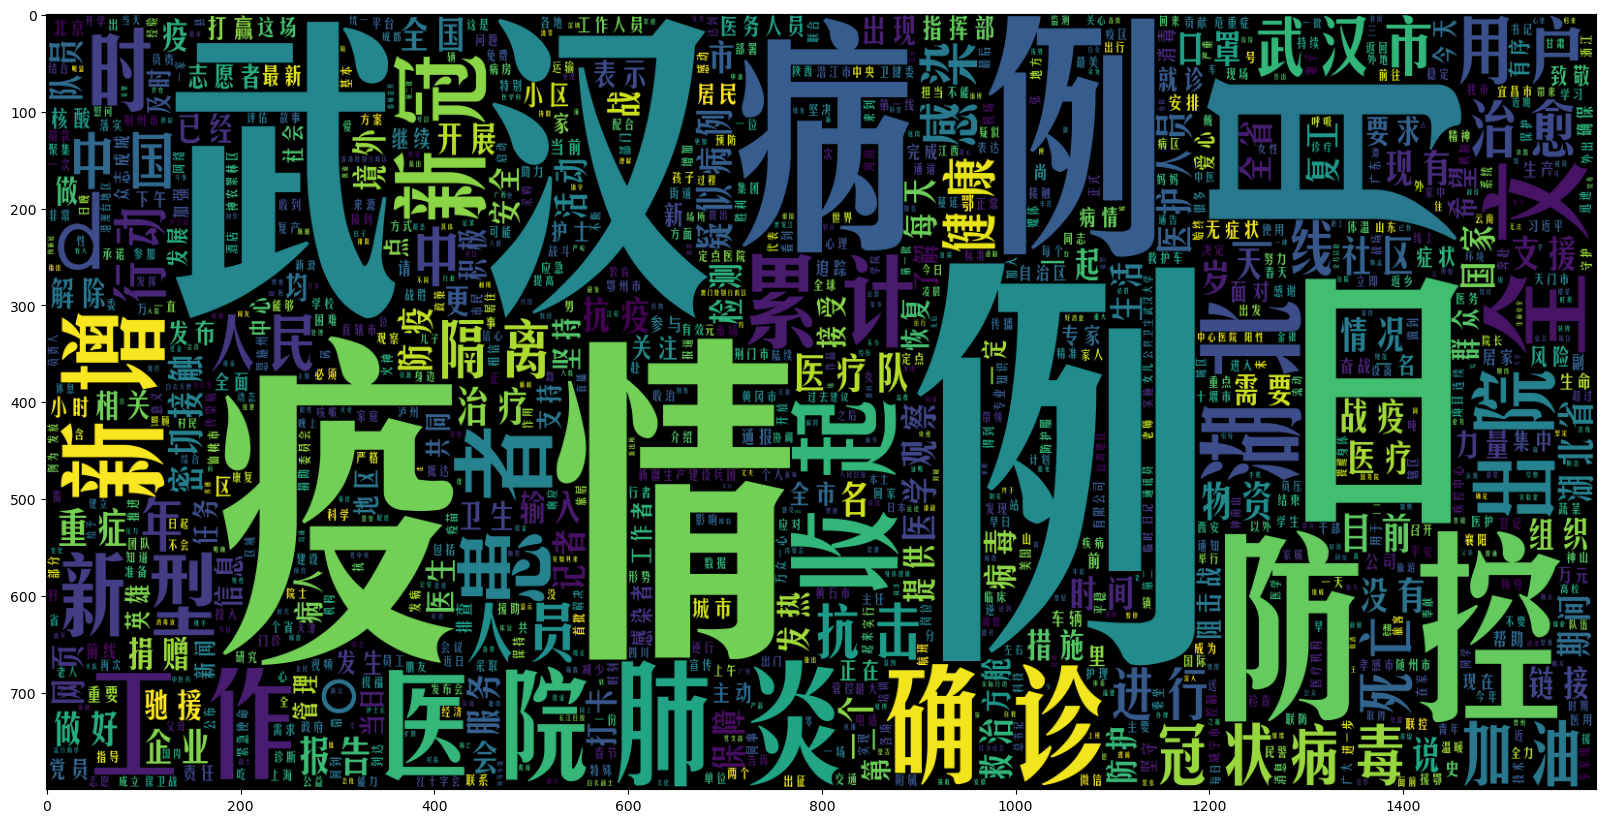

In [21]:
data_pos = processedtext[43121:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800, font_path=font,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)